# epymorph: migrating from v0.4 to v0.5

An interactive workshop of side-by-side comparisons: this is the v0.5 version.

Running simulation (BasicSimulator):
• 2015-01-01 to 2016-08-23 (600 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.069s


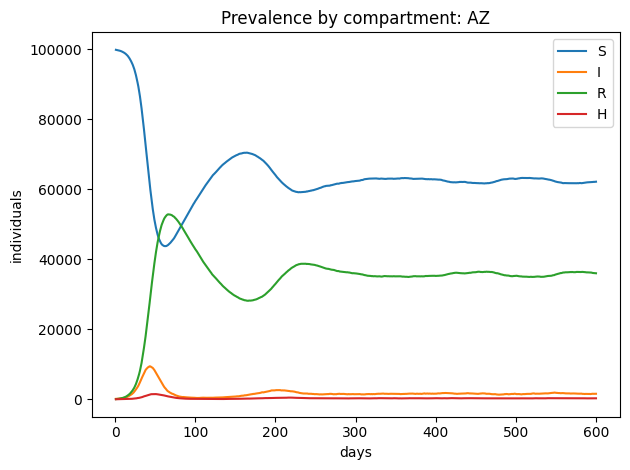

In [1]:
# Example 1: basic simulation
# watch for changes -- RUME, Simulators, Initializers, geo usage

from epymorph import *

geo = geo_library['single_pop']()

rume = Rume.single_strata(
    ipm=ipm_library['sirh'](),
    mm=mm_library['no'](),
    init=init.SingleLocation(location=0, seed_size=100),
    scope=geo.spec.scope,
    time_frame=TimeFrame.of("2015-01-01", 600),
    params={
        'beta': 0.4,
        'gamma': 1 / 4,
        'xi': 1 / 90,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7,
        'population': geo['population'],
        'meta::geo::label': geo['label'],
    },
)

sim = BasicSimulator(rume)
with sim_messaging(sim):
    output = sim.run(
        # params={'beta': 0.9},
        rng_factory=default_rng(42),
    )

plot_pop(output, pop_idx=0)

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.146s


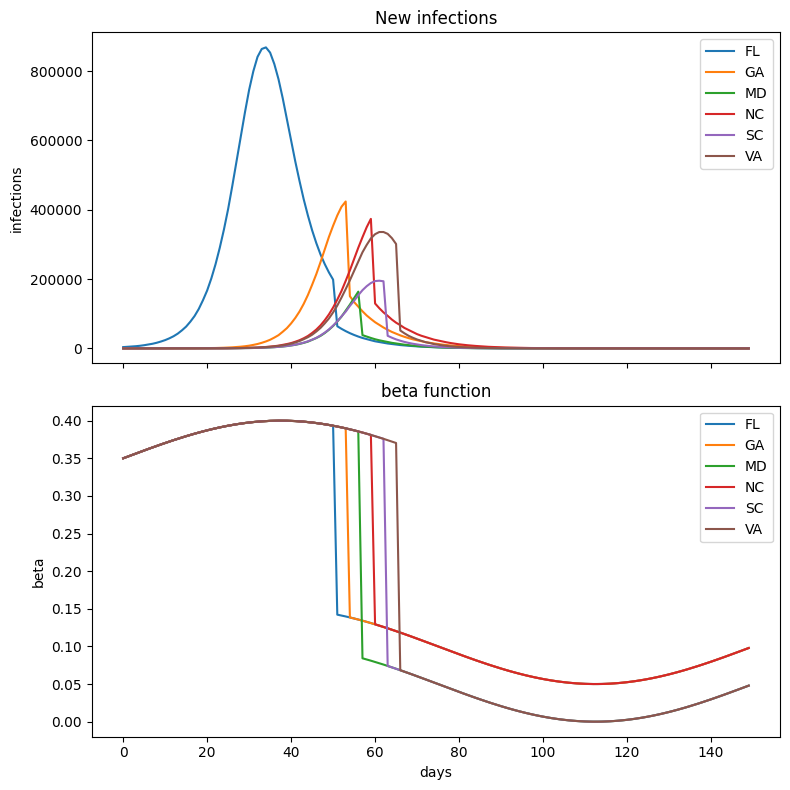

In [2]:
# Example 2: custom parameter functions
# watch for changes -- defining and evaluating params functions which access data attributes

from math import pi, sin

import matplotlib.pyplot as plt
import numpy as np

from epymorph import *
from epymorph.params import ParamFunctionTimeAndNode
from epymorph.simulator.data import evaluate_param

POPULATION = AttributeDef('population', int, Shapes.N)


class Beta(ParamFunctionTimeAndNode):

    attributes = [POPULATION]

    def evaluate1(self, day: int, node_index: int) -> float:
        x = 0.35 + 0.05 * sin(2 * pi * (day / self.dim.days))
        cutoff = 50 + (node_index * 3)
        if day > cutoff:
            pop = self.data(POPULATION)[node_index]
            cut = 0.3 if pop < 9_000_000 else 0.25
            x -= cut
        return x


geo = geo_library['pei']()

rume = Rume.single_strata(
    scope=geo.spec.scope,
    ipm=ipm_library['sirs'](),
    mm=mm_library['pei'](),
    init=init.SingleLocation(location=0, seed_size=10_000),
    time_frame=TimeFrame.of("2015-01-01", 150),
    params={
        'beta': Beta(),
        'gamma': 1 / 6,
        'xi': 1 / 90,
        'theta': 0.1,
        'move_control': 0.9,
        'population': geo['population'],
        'commuters': geo['commuters'],
        'meta::geo::label': geo['label'],
    },
)

sim = BasicSimulator(rume)
with sim_messaging(sim):
    out = sim.run()

# For the sake of graphing beta, I need to evaluate beta in the context of the RUME.
beta_values = evaluate_param(rume, 'beta')


### GRAPHS ###
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8))
x_axis = np.arange(out.dim.days)
ax1.set(title='New infections', ylabel='infections')
ax1.plot(x_axis, out.incidence_per_day[:, :, 0], label=out.geo_labels)
ax1.legend()

ax2.set(title='beta function', ylabel='beta', xlabel='days')
ax2.plot(x_axis, beta_values, label=out.geo_labels)
ax2.legend()

fig.tight_layout()
plt.show()

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-02-20 (50 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.016s


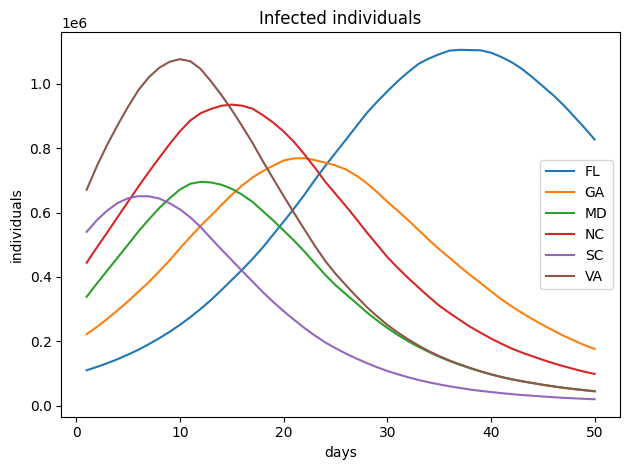

In [3]:
# Example 3: custom initialization
# watch for changes -- defining initializers, class parameterization

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

from epymorph import *
from epymorph.initializer import Initializer

POPULATION = AttributeDef('population', int, Shapes.N)


class MyInitializer(Initializer):

    attributes = [POPULATION]

    infected_multiplier: int

    def __init__(self, infected_multiplier: int = 100_000):
        self.infected_multiplier = infected_multiplier

    def evaluate(self) -> NDArray[SimDType]:
        _, N, C, _ = self.dim.TNCE
        initial = np.zeros(shape=(N, C), dtype=SimDType)
        initial[:, 0] = self.data(POPULATION)
        for n in range(N):
            initial[n, 0] -= self.infected_multiplier * (n + 1)
            initial[n, 1] += self.infected_multiplier * (n + 1)
        return initial


geo = geo_library['pei']()

rume = Rume.single_strata(
    scope=geo.spec.scope,
    ipm=ipm_library['pei'](),
    mm=mm_library['no'](),
    init=MyInitializer(),
    # init=MyInitializer(10000),
    time_frame=TimeFrame.of("2015-01-01", duration_days=50),
    params={
        'infection_duration': 4,
        'immunity_duration': 90,
        'population': geo['population'],
        'humidity': geo['humidity'],
        'meta::geo::label': geo['label'],
    },
)

sim = BasicSimulator(rume)
with sim_messaging(sim):
    out = sim.run()


### GRAPHS ###
fig, ax = plt.subplots()
ax.set_title(f"Infected individuals")
ax.set_xlabel('days')
ax.set_ylabel('individuals')
ax.plot(out.ticks_in_days, out.prevalence[:, :, 1], label=out.geo_labels)
ax.legend()
fig.tight_layout()
plt.show()

In [4]:
# Example 4: construct a multistrata RUME

from functools import reduce

import matplotlib.pyplot as plt
import numpy as np

import epymorph.geo.adrio.acs5 as acs5
import epymorph.geo.adrio.us_tiger as tiger
from epymorph import *
from epymorph.compartment_model import TransitionDef, edge
from epymorph.geography.us_census import TractScope
from epymorph.simulator.data import evaluate_param

# Select 21 census tracts out of Maricopa County, AZ
maricopa_tracts = TractScope.in_counties(['04013'], year=2020)

subset_tracts = maricopa_tracts.get_node_ids()[::33][0:21]

scope = TractScope.in_tracts(subset_tracts.tolist())

print(f"The census tracts we'll model:\n{scope.get_node_ids()}")


# age_00-19
gpm1 = Gpm(
    ipm=ipm_library['sirs'](),
    mm=mm_library['centroids'](),
    init=init.NoInfection(),
)

# age_20-59
gpm2 = Gpm(
    ipm=ipm_library['sirs'](),
    mm=mm_library['centroids'](),
    init=init.SingleLocation(location=0, seed_size=100),
)

# age_60-79
gpm3 = Gpm(
    ipm=ipm_library['sirs'](),
    mm=mm_library['no'](),
    init=init.NoInfection(),
)


meta_attributes = [
    AttributeDef("beta_12", float, Shapes.TxN),
    AttributeDef("beta_13", float, Shapes.TxN),
    AttributeDef("beta_21", float, Shapes.TxN),
    AttributeDef("beta_23", float, Shapes.TxN),
    AttributeDef("beta_31", float, Shapes.TxN),
    AttributeDef("beta_32", float, Shapes.TxN),
]


def build_meta_edges(rs: RumeSymbols) -> list[TransitionDef]:
    # extract compartment symbols by strata
    S_1, I_1, R_1 = rs.compartments("age_00-19")
    S_2, I_2, R_2 = rs.compartments("age_20-59")
    S_3, I_3, R_3 = rs.compartments("age_60-79")

    # extract compartment totals by strata
    N_1 = rs.total_nonzero("age_00-19")
    N_2 = rs.total_nonzero("age_20-59")
    N_3 = rs.total_nonzero("age_60-79")

    # extract meta attributes
    beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = rs.meta_attributes()

    return [
        edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
        edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
        edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
        edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
        edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
        edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
    ]


rume = Rume.multistrata(
    strata=[
        ("age_00-19", gpm1),
        ("age_20-59", gpm2),
        ("age_60-79", gpm3),
    ],
    meta_attributes=meta_attributes,
    meta_edges=build_meta_edges,
    scope=scope,
    time_frame=TimeFrame.of("2020-01-01", 180),
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta": 0.05,
        "gpm:age_20-59::ipm::beta": 0.20,
        "gpm:age_60-79::ipm::beta": 0.35,
        "*::ipm::gamma": 1 / 10,
        "*::ipm::xi": 1 / 90,
        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,

        # MM params
        "gpm:age_00-19::mm::phi": 20.0,
        "gpm:age_20-59::mm::phi": 40.0,
        "gpm:age_60-79::mm::phi": 30.0,

        # ADRIO things!
        "*::*::centroid": tiger.InternalPoint(),
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

The census tracts we'll model:
['04013010102' '04013050603' '04013061027' '04013061061' '04013071913'
 '04013092305' '04013093104' '04013103612' '04013104502' '04013106502'
 '04013108601' '04013110502' '04013112507' '04013114000' '04013116607'
 '04013116732' '04013216838' '04013217502' '04013319710' '04013420210'
 '04013421102']


Evaluating PopulationByAgeTable ADRIO...
Completed PopulationByAgeTable ADRIO (26.998s).
Evaluating PopulationByAge ADRIO...
Completed PopulationByAge ADRIO (0.000s).
Evaluating InternalPoint ADRIO...
Completed InternalPoint ADRIO (4.910s).
Evaluating PopulationByAge ADRIO...
Completed PopulationByAge ADRIO (0.000s).
Evaluating PopulationByAge ADRIO...
Completed PopulationByAge ADRIO (0.000s).
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-06-29 (180 days)
• 21 geo nodes
|####################| 100% 
Runtime: 1.803s


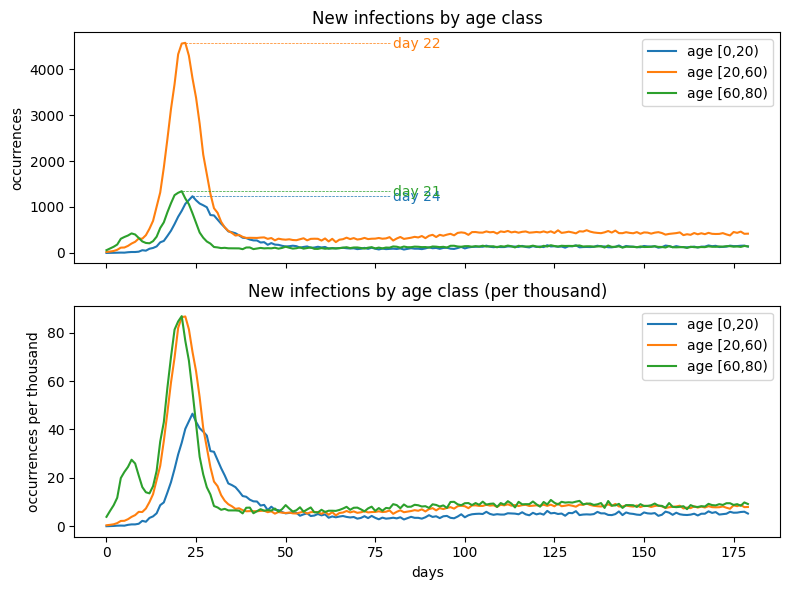

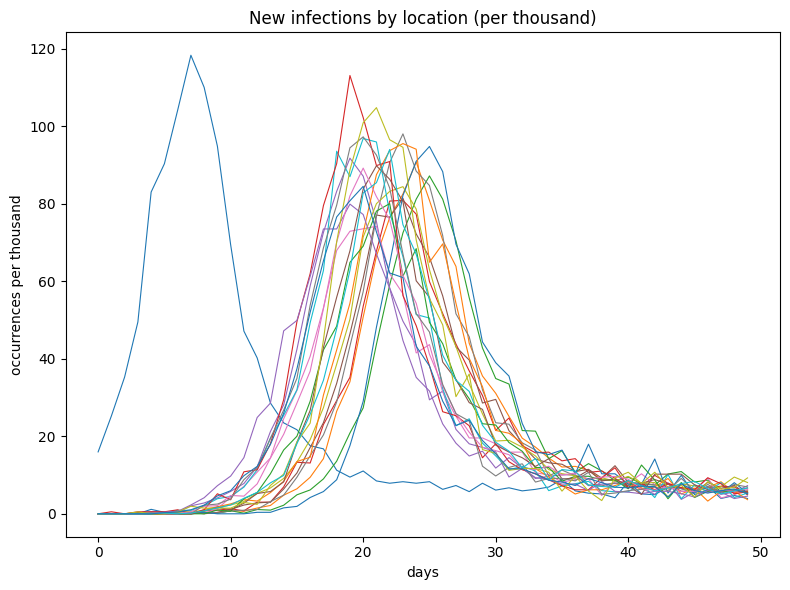

In [5]:
# Example 4: now run it

sim = BasicSimulator(rume)
with sim_messaging(sim):
    out = sim.run()


# calc total new infections (depending on the IPM this may represent this as separate events)
infection_events = [
    rume.ipm.events_by_dst("I_age_00-19"),
    rume.ipm.events_by_dst("I_age_20-59"),
    rume.ipm.events_by_dst("I_age_60-79"),
]

infections = np.array([
    reduce(lambda a, b: a + b,
           (out.incidence_per_day[:, :, j].sum(axis=1) for j in infection_events[i]))
    for i in [0, 1, 2]
])


### GRAPHS ###

pop_00_19 = evaluate_param(rume, 'gpm:age_00-19::_::population')
pop_20_59 = evaluate_param(rume, 'gpm:age_20-59::_::population')
pop_60_79 = evaluate_param(rume, 'gpm:age_60-79::_::population')

# Plot infections by age class
age_label = ['age [0,20)', 'age [20,60)', 'age [60,80)']
age_total_thousands = np.array([pop_00_19, pop_20_59, pop_60_79])\
    .sum(axis=1) / 1000
t_window = slice(0, None)

# Day of Peak Infection by age class
dpi = [
    int(np.argmax(infections[i]))
    for i in [0, 1, 2]
]
max_y_value = infections.max()
dpi_x_pos = 80  # an absolute x offset (to keep them horizontally aligned)
dpi_y_pos = -0.025 * max_y_value  # an offset from the peak's y position

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
x_axis = np.arange(out.dim.days)[t_window]

ax1.set_title('New infections by age class')
ax1.set_ylabel('occurrences')
for i in [0, 1, 2]:
    color = ax1._get_lines.get_next_color()
    y_axis = infections[i][t_window]
    ax1.plot(x_axis, y_axis, color=color, label=age_label[i])
    # Mark day of peak infection
    d = dpi[i]
    ax1.text(dpi_x_pos, y_axis[d] + dpi_y_pos, f"day {d}", color=color)
    ax1.hlines(y=y_axis[d], xmin=d, xmax=dpi_x_pos - 1,
               color=color, linewidth=0.5, linestyle='dashed')
ax1.legend()

ax2.set_title('New infections by age class (per thousand)')
ax2.set_xlabel('days')
ax2.set_ylabel('occurrences per thousand')
for i in [0, 1, 2]:
    y_axis = infections[i][t_window] / age_total_thousands[i]
    ax2.plot(x_axis, y_axis, label=age_label[i])
ax2.legend()

fig.tight_layout()
plt.show()


# Plot infections by location
pop_total_thousands = (pop_00_19 + pop_20_59 + pop_60_79) / 1000

t_window = slice(0, 50)

infections_by_loc = out.incidence_per_day[:, :, rume.ipm.events_by_dst("I_age_*")]\
    .sum(axis=2, dtype=np.int64)

fig, ax = plt.subplots(figsize=(8, 6))
x_axis = np.arange(out.dim.days)[t_window]
ax.set_title('New infections by location (per thousand)')
ax.set_xlabel('days')
ax.set_ylabel('occurrences per thousand')
for n in range(rume.dim.nodes):
    y_axis = infections_by_loc[t_window, n] / pop_total_thousands[n]
    ax.plot(x_axis, y_axis, linewidth=0.8)

fig.tight_layout()
plt.show()

In [6]:
# Example 4...
print(rume.params_description())

gpm:age_00-19::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_00-19::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_00-19::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

gpm:age_20-59::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_20-59::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_20-59::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

gpm:age_60-79::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_60-79::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_60-79::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

meta::ipm::beta_12 (type: float, shape: TxN)

meta::ipm::beta_13 (type: float, shape: TxN)

meta::ipm::beta_21 (type: float, shape: TxN)

meta::ipm::beta_23 (type: float, shape: TxN)

meta::ipm::beta_31 (type: float, sha

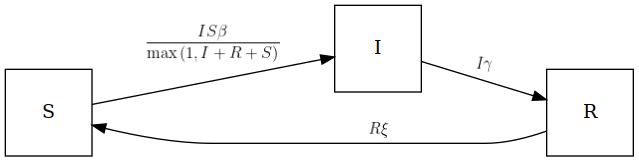

In [7]:
# Example 4...
render(gpm1.ipm)

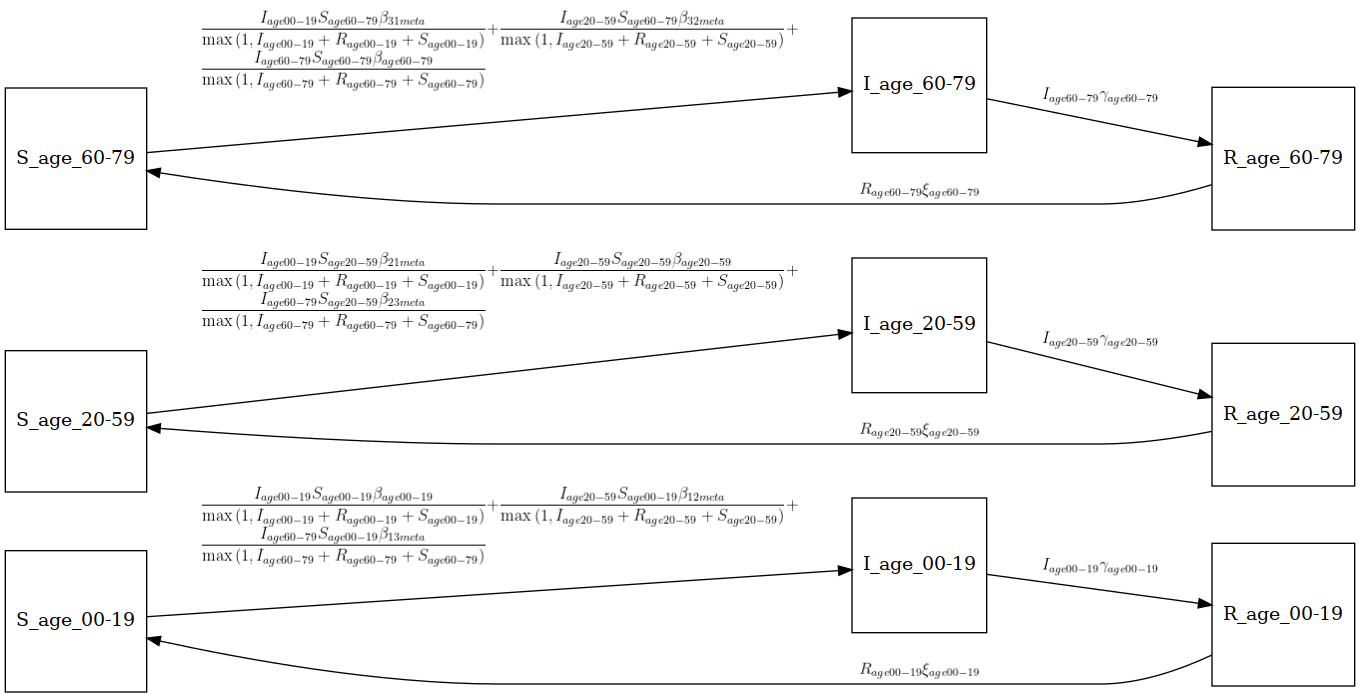

In [8]:
# Example 4...
render(rume.ipm)